## Train probe
- Goal: To train MVP probes on activations
    - Maybe make those probes be fancy (mean, attention, softmax)
    - Maybe make those activations be real

### Do probe training (HF dataset activations)

Load the activations and labels from HF, aggregate, and construct datasets to train the probe on (note sklearn doesn't require a validation dataset).

In [1]:
import probe_gen.probes as probes
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [2]:
# Load the activations and labels from hf
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", 20)
# Aggregate the activations
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

loaded labels
loaded activations
calculated attention mask
Train: 230 samples, 115.0 positives
Val:   0 samples, 0.0 positives
Test:  56 samples, 28.0 positives


Create a probe and fit it.

In [6]:
# Initialise and fit a probe with the datasets
probe = probes.SklearnLogisticProbe(use_bias=False)
probe.fit(train_dataset, val_dataset, normalize=True)

Training probe...


Evaluate the probe on test dataset.

In [ ]:
# Make predictions
y_pred = probe.predict(test_dataset['X'])
y_pred_proba = probe.predict_proba(test_dataset['X'])  # probabilities for class 1

# Evaluate the model
eval_dict, _, _ = probe.eval(test_dataset)
print(eval_dict)
print(type(classification_report(test_dataset['y'], y_pred)))

{'accuracy': 0.875, 'roc_auc': 0.9477040816326531, 'tpr_at_1_fpr': np.float64(0.5)}
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88        28
         1.0       0.89      0.86      0.87        28

    accuracy                           0.88        56
   macro avg       0.88      0.88      0.87        56
weighted avg       0.88      0.88      0.87        56



In [ ]:
# Make predictions
y_pred2 = probe.predict(test_dataset2['X'])
y_pred_proba2 = probe.predict_proba(test_dataset2['X'])  # probabilities for class 1

# Evaluate the model
eval_dict2, y_pred2, y_pred_proba2 = probe.eval(test_dataset2)
print(eval_dict2)
print(type(classification_report(test_dataset2['y'], y_pred)))

{'accuracy': 0.8035714285714286, 'roc_auc': 0.9183673469387754, 'tpr_at_1_fpr': np.float64(0.42857142857142855)}
<class 'str'>


Nice visualisation to see how the probe splits the two classes

In [ ]:
import matplotlib.pyplot as plt

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 1, 1)
plt.hist(y_pred_proba[test_dataset['y'].numpy() == 0], alpha=0.5, label='Complied', bins=20)
plt.hist(y_pred_proba[test_dataset['y'].numpy() == 1], alpha=0.5, label='Rejected', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

plt.tight_layout()
plt.show()

[{'run_id': 'j03booay', 'run_name': 'rare-dust-1', 'accuracy': 0.8214285714285714, 'train_dataset': 'refusal_train', 'test_dataset': 'refusal_test'}, {'run_id': 'p8da1gol', 'run_name': 'dashing-lion-2', 'accuracy': 0.7857142857142857, 'train_dataset': 'refusal_train', 'test_dataset': 'refusal_val'}]
Run rare-dust-1: Accuracy = 0.821
Run dashing-lion-2: Accuracy = 0.786


# Testing On-Off Probes

In [3]:
import probe_gen.probes as probes
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", 18)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
train_dataset_on, val_dataset_on, test_dataset_on = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__off_policy_other_model", "../data/refusal/off_policy_raw.jsonl", 18)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
train_dataset_off, val_dataset_off, test_dataset_off = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

loaded labels
loaded activations
calculated attention mask
Train: 230 samples, 115.0 positives
Val:   0 samples, 0.0 positives
Test:  56 samples, 28.0 positives
loaded labels
loaded activations
calculated attention mask
Train: 418 samples, 209.0 positives
Val:   0 samples, 0.0 positives
Test:  104 samples, 52.0 positives


In [4]:
# Initialise and fit a probe with the datasets
probe_on = probes.SklearnLogisticProbe(use_bias=False)
probe_on.fit(train_dataset_on, val_dataset_on, normalize=True)
# Initialise and fit a probe with the datasets
probe_off = probes.SklearnLogisticProbe(use_bias=False)
probe_off.fit(train_dataset_off, val_dataset_off, normalize=True)

Training probe...
Training probe...


In [5]:
eval_dict_on_on, _, _ = probe_on.eval(test_dataset_on)
eval_dict_on_off, _, _ = probe_on.eval(test_dataset_off)
eval_dict_off_on, _, _ = probe_off.eval(test_dataset_on)
eval_dict_off_off, _, _ = probe_off.eval(test_dataset_off)
print(eval_dict_on_on)
print(eval_dict_on_off)
print(eval_dict_off_on)
print(eval_dict_off_off)

{'accuracy': 0.9107142857142857, 'roc_auc': 0.9477040816326531, 'tpr_at_1_fpr': np.float64(0.4642857142857143)}
{'accuracy': 0.6057692307692307, 'roc_auc': 0.7444526627218935, 'tpr_at_1_fpr': np.float64(0.19230769230769232)}
{'accuracy': 0.7678571428571429, 'roc_auc': 0.8762755102040817, 'tpr_at_1_fpr': np.float64(0.39285714285714285)}
{'accuracy': 0.75, 'roc_auc': 0.8180473372781065, 'tpr_at_1_fpr': np.float64(0.40384615384615385)}


In [10]:
key = 'accuracy'

print(f"             on                   off                {key}")
print(f"on    {eval_dict_on_on[key]}   {eval_dict_on_off[key]}")
print(f"off   {eval_dict_off_on[key]}   {eval_dict_off_off[key]}")

             on                   off                accuracy
on    0.9107142857142857   0.6057692307692307
off   0.7678571428571429   0.75


In [7]:
import wandb
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import numpy as np

def save_probe_eval_results(eval_dict, train_set, test_set):
    # Initialize wandb run
    wandb.init(
        project="LASR_probe_gen",
        entity="samdower",
        config={
            "model_type": "mean",
            "train_dataset": train_set,
            "test_dataset": test_set
        }
    )

    # Log metrics
    wandb.log({
        "accuracy": eval_dict['accuracy'],
        "roc_auc": eval_dict['roc_auc'],
        "tpr_at_1_fpr": eval_dict['tpr_at_1_fpr'],
    })

    # Finish the run
    wandb.finish()

In [ ]:
save_probe_eval_results(eval_dict_on_on, "refusal_on", "refusal_on")
save_probe_eval_results(eval_dict_on_off, "refusal_on", "refusal_off")
save_probe_eval_results(eval_dict_off_on, "refusal_off", "refusal_on")
save_probe_eval_results(eval_dict_off_off, "refusal_off", "refusal_off")

{'run_id': 'akkv25ui', 'run_name': 'wandering-dust-3', 'accuracy': 0.9107142857142856, 'roc_auc': 0.9477040816326532, 'tpr_at_1_fpr': 0.4642857142857143, 'train_dataset': 'refusal_on', 'test_dataset': 'refusal_on'}
<class 'float'>
{'run_id': '0jlnjmfn', 'run_name': 'amber-durian-4', 'accuracy': 0.6057692307692307, 'roc_auc': 0.7444526627218935, 'tpr_at_1_fpr': 0.19230769230769232, 'train_dataset': 'refusal_on', 'test_dataset': 'refusal_off'}
<class 'float'>
{'run_id': 'dcua7g9x', 'run_name': 'avid-firebrand-5', 'accuracy': 0.7678571428571429, 'roc_auc': 0.8762755102040817, 'tpr_at_1_fpr': 0.3928571428571429, 'train_dataset': 'refusal_off', 'test_dataset': 'refusal_on'}
<class 'float'>
{'run_id': 'dlutl75w', 'run_name': 'rosy-frog-6', 'accuracy': 0.75, 'roc_auc': 0.8180473372781065, 'tpr_at_1_fpr': 0.40384615384615385, 'train_dataset': 'refusal_off', 'test_dataset': 'refusal_off'}
<class 'float'>


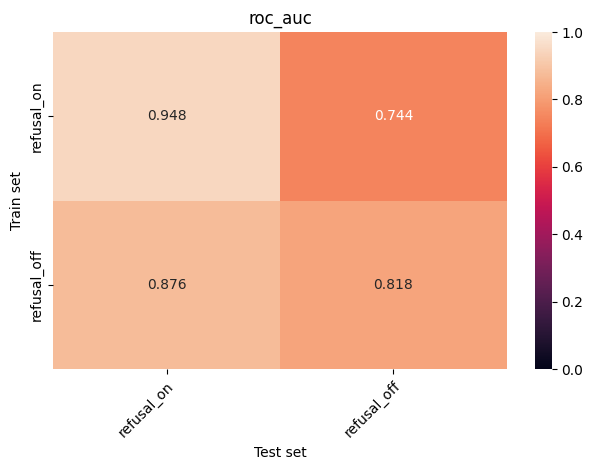

In [2]:
from probe_gen.standard_experiments.experiment_plotting import plot_results_table

plot_results_table(['refusal_on', 'refusal_off'], 'roc_auc')

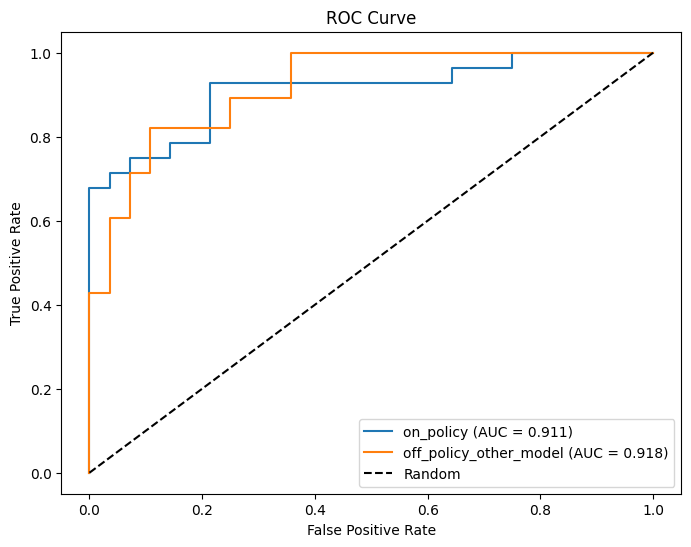

In [20]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_dataset['y'], y_pred_proba)
fpr2, tpr2, thresholds2 = roc_curve(test_dataset2['y'], y_pred_proba2)

roc_auc = eval_dict['roc_auc']
roc_auc2 = eval_dict2['roc_auc']

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'on_policy (AUC = {roc_auc:.3f})')
plt.plot(fpr2, tpr2, label=f'off_policy_other_model (AUC = {roc_auc2:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Layer experiments

In [1]:
import probe_gen.probes as probes
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [10]:
accuracies_on = []
roc_aucs_on = []
for i in range(18, 28):
    print(f"######################### {i} #############################")

    # Load the activations and labels from hf
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", i)
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

    # Initialise and fit a probe with the datasets
    probe = probes.SklearnLogisticProbe(use_bias=False)
    probe.fit(train_dataset, val_dataset, normalize=True)

    # Evaluate the model
    eval_dict, _, _ = probe.eval(test_dataset)
    accuracies_on.append(eval_dict['accuracy'])
    roc_aucs_on.append(eval_dict['roc_auc'])

print(accuracies_on)
print(roc_aucs_on)

######################### 18 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
loaded activations
calculated attention mask
Train: 230 samples, 115.0 positives
Val:   0 samples, 0.0 positives
Test:  56 samples, 28.0 positives
Training probe...
######################### 19 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
loaded activations
calculated attention mask
Train: 230 samples, 115.0 positives
Val:   0 samples, 0.0 positives
Test:  56 samples, 28.0 positives
Training probe...
######################### 20 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
loaded activations
calculated attention mask
Train: 230 samples, 115.0 positives
Val:   0 samples, 0.0 positives
Test:  56 samples, 28.0 positives
Training probe...
######################### 21 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
loade

In [12]:
accuracies_off = []
roc_aucs_off = []
for i in range(18, 28):
    print(f"######################### {i} #############################")

    # Load the activations and labels from hf
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__off_policy_other_model", "../data/refusal/off_policy_raw.jsonl", i)
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

    # Initialise and fit a probe with the datasets
    probe = probes.SklearnLogisticProbe(use_bias=False)
    probe.fit(train_dataset, val_dataset, normalize=True)

    # Evaluate the model
    eval_dict, _, _ = probe.eval(test_dataset)
    accuracies_off.append(eval_dict['accuracy'])
    roc_aucs_off.append(eval_dict['roc_auc'])

print(accuracies_off)
print(roc_aucs_off)

######################### 18 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
loaded activations
calculated attention mask
Train: 418 samples, 209.0 positives
Val:   0 samples, 0.0 positives
Test:  104 samples, 52.0 positives
Training probe...
######################### 19 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
loaded activations
calculated attention mask
Train: 418 samples, 209.0 positives
Val:   0 samples, 0.0 positives
Test:  104 samples, 52.0 positives
Training probe...
######################### 20 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
loaded activations
calculated attention mask
Train: 418 samples, 209.0 positives
Val:   0 samples, 0.0 positives
Test:  104 samples, 52.0 positives
Training probe...
######################### 21 #############################
loaded labels
dict_keys([18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
lo

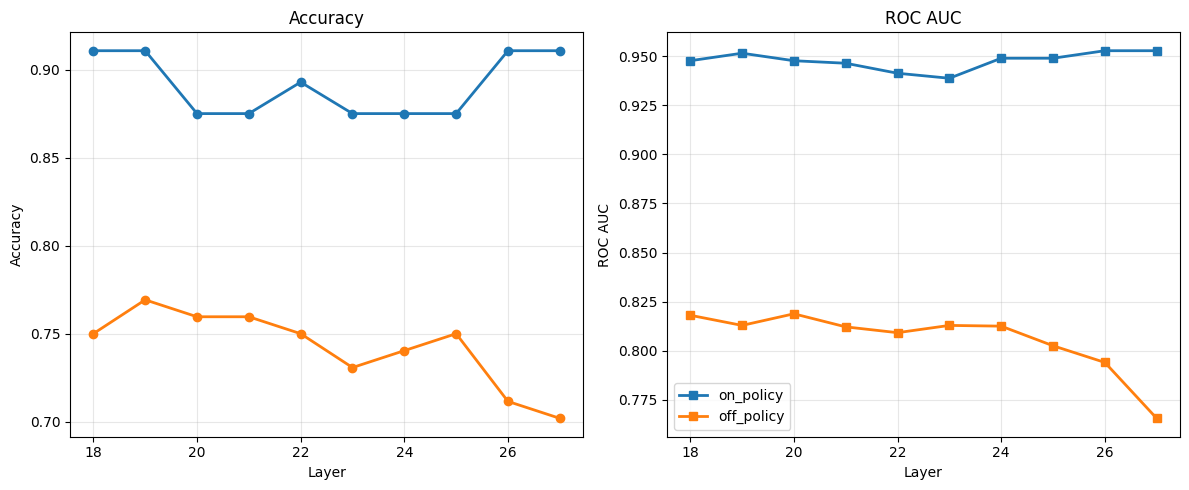

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracies
ax1.plot([i for i in range(18,28)], accuracies_on, marker='o', linewidth=2, markersize=6, label='on_policy')
ax1.plot([i for i in range(18,28)], accuracies_off, marker='o', linewidth=2, markersize=6, label='off_policy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Accuracy')
ax1.grid(True, alpha=0.3)

# Plot ROC AUCs
ax2.plot([i for i in range(18,28)], roc_aucs_on, marker='s', linewidth=2, markersize=6, label='on_policy')
ax2.plot([i for i in range(18,28)], roc_aucs_off, marker='s', linewidth=2, markersize=6, label='off_policy')
ax2.set_title('ROC AUC')
ax2.set_xlabel('Layer')
ax2.set_ylabel('ROC AUC')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.legend()
plt.show()

# Torch training (not yet integrated / needed)

In [ ]:
# Now actually train the probe on training data and evaluate on test data
import matplotlib.pyplot as plt
from probe_gen.probe_train import train_probe, evaluate_probe

print("Training linear probe...")
print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

# Train probe
model, train_losses, val_losses = train_probe(
    train_activations=train_activations,
    train_labels=train_labels,
    val_activations=val_activations,
    val_labels=val_labels,
    probe_type="mean",
    learning_rate=5e-3,
    batch_size=16,
    num_epochs=100,
    early_stop_patience=20,
    silent=True
)

# Evaluate probe
print("\nEvaluating probe...")
results = evaluate_probe(model, test_activations, test_labels)

print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC-ROC: {results['auc_roc']:.4f}")
print(f"TPR at 1% FPR: {results['tpr_at_1_fpr']:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(results['probabilities'][test_labels.numpy() == 0], alpha=0.5, label='Complied', bins=20)
plt.hist(results['probabilities'][test_labels.numpy() == 1], alpha=0.5, label='Rejected', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn
# Show some values
criterion = nn.BCEWithLogitsLoss()
for i in range(10):
    logits = model(train_activations[i:i+1,:,:])
    print(train_labels[i], logits[0])
    print(torch.sigmoid(logits[0]))
    print(torch.sigmoid(logits[0]) > 0.5)
    print(criterion(logits[0], train_labels[i].float()))
    print()

### Do probe experiments (HF dataset activations)

In [ ]:
import json
import torch
import pandas as pd
from huggingface_hub import hf_hub_download
from probe_gen.probe_train import train_probe, evaluate_probe

for layer_num in range(5):
    print(f"\n\nLayer {layer_num}")
    # Load the labels
    labels_list = []
    with open("../data/refusal/on_policy_raw.jsonl", 'r') as file:
        for line in file:
            data = json.loads(line)
            if data["scale_labels"] <= 5:
                labels_list.append(1.0)
            else:
                labels_list.append(0.0)
    labels_tensor = torch.tensor(labels_list)
    print("loaded labels")

    # Load activations
    file_path = hf_hub_download(
        repo_id="NLie2/anthropic-refusal-activations",
        filename="dataframe_with_activations.pkl",
        repo_type="dataset")
    df = pd.read_pickle(file_path)
    print(f"loaded activations, with shape: {df.shape}")

    # Extract all activations
    all_activations = []
    for i in range(len(df)):
        all_activations.append(df.loc[i]["activations"][0])
    activations_tensor = torch.cat(all_activations, dim=0).unsqueeze(1).to(torch.float32)

    # Get indices for each label
    label_0_indices = (labels_tensor == 0.0).nonzero(as_tuple=True)[0]
    label_1_indices = (labels_tensor == 1.0).nonzero(as_tuple=True)[0]
    min_class_count = min(len(label_0_indices), len(label_1_indices))

    # Subsample both classes to same size
    label_0_indices = label_0_indices[:min_class_count]
    label_1_indices = label_1_indices[:min_class_count]

    # Shuffle indices
    label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))]
    label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))]

    # Compute split sizes
    n_total = min_class_count
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    # Split label 0s
    train_0 = label_0_indices[:n_train]
    val_0 = label_0_indices[n_train:n_train + n_val]
    test_0 = label_0_indices[n_train + n_val:]

    # Split label 1s
    train_1 = label_1_indices[:n_train]
    val_1 = label_1_indices[n_train:n_train + n_val]
    test_1 = label_1_indices[n_train + n_val:]

    # Concatenate splits and shuffle within each
    def get_split(indices_0, indices_1):
        indices = torch.cat([indices_0, indices_1])
        indices = indices[torch.randperm(len(indices))]
        return activations_tensor[indices], labels_tensor[indices]

    train_activations, train_labels = get_split(train_0, train_1)
    val_activations, val_labels = get_split(val_0, val_1)
    test_activations, test_labels = get_split(test_0, test_1)

    # Confirm balance
    print(f"Train: {train_labels.shape[0]} samples, {train_labels.sum()} positives")
    print(f"Val:   {val_labels.shape[0]} samples, {val_labels.sum()} positives")
    print(f"Test:  {test_labels.shape[0]} samples, {test_labels.sum()} positives")

    # Now actually train the probe on training data and evaluate on test data

    print("Training linear probe...")
    print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

    # Train probe
    model, train_losses, val_losses = train_probe(
        train_activations=train_activations,
        train_labels=train_labels,
        val_activations=val_activations,
        val_labels=val_labels,
        probe_type="mean",
        learning_rate=5e-3,
        batch_size=16,
        num_epochs=100,
        early_stop_patience=20,
        silent=True
    )

    # Evaluate probe
    print("\nEvaluating probe...")
    results = evaluate_probe(model, test_activations, test_labels)

    print("Test Accuracy, Test AUC-ROC, TPR at 1% FPR")
    print(f"{results['accuracy']:.4f}\t{results['auc_roc']:.4f}\t{results['tpr_at_1_fpr']:.4f}")
